# 05_early_warning_demo1

Observed weeks in nat: 209 from 2018 to 2021
Simulated series length (weeks): 209


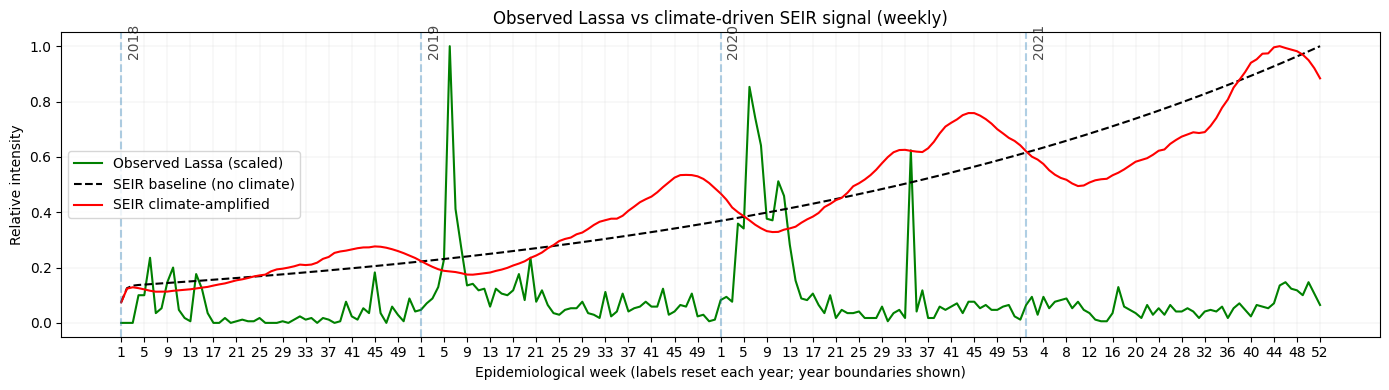

Saved: ../reports/figures/seir_baseline_vs_climate.png


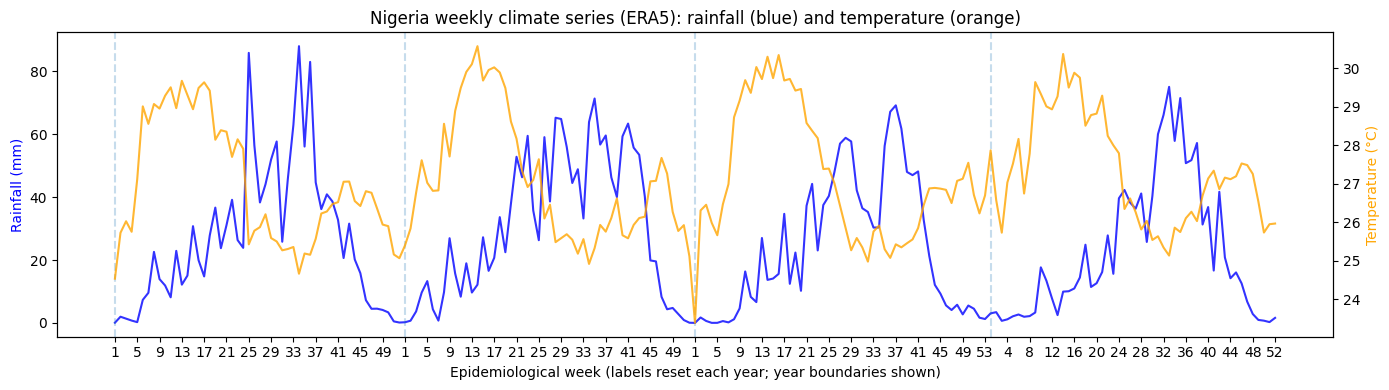

Saved: ../reports/figures/weekly_climate_rain_temp.png


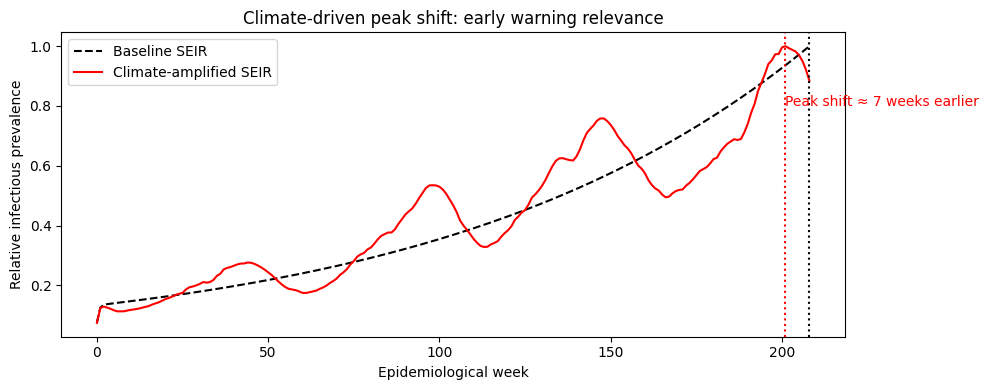

Saved: ../reports/figures/seir_peak_shift_early_warning.png


In [8]:
# FIX SEIR length + scaling (drop-in cells)
# Works for: (A) validation 2018–2021 using your existing weekly panel
# and (B) projection to 2026 if you append future climate rows later.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# -----------------------
# 1) LOAD + PREP WEEKLY CLIMATE (NATIONAL MEAN)
# -----------------------
panel_path = "../data/processed/model/lassa_era5_weekly_panel_2018_2021.csv"
df = pd.read_csv(panel_path)

# national weekly aggregation (mean climate, sum cases)
nat = df.groupby(["year","week"], as_index=False).agg(
    cases=("cases","sum"),
    rain_mm=("rain_mm","mean"),
    temp_c=("temp_c","mean"),
).sort_values(["year","week"]).reset_index(drop=True)

# create a proper continuous time index and year/week labels
nat["t"] = np.arange(len(nat))

# sanity
print("Observed weeks in nat:", len(nat), "from", nat["year"].min(), "to", nat["year"].max())

# -----------------------
# 2) DEFINE SIMULATION HORIZON (THIS IS THE 'LENGTH' FIX)
# -----------------------
# Validation horizon: match observed exactly
T = len(nat)  # <-- this is the key fix (instead of hard-coding 2000)
print("Simulated series length (weeks):", T)

# If later you add climate rows up to 2026, nat will become longer automatically
# and T will increase accordingly.

# -----------------------
# 3a) BUILD A CLIMATE-DRIVEN TRANSMISSION MODIFIER
#    (simple, interpretable proxy; replace with your own if you already have one)
# -----------------------
def zscore(x):
    x = np.asarray(x, dtype=float)
    return (x - np.nanmean(x)) / (np.nanstd(x) + 1e-9)

rain_z = zscore(nat["rain_mm"].values)
temp_z = zscore(nat["temp_c"].values)

# A simple weekly forcing signal (keep it small so it doesn't explode)
# You can tune a_rain/a_temp later or fit them.
a_rain = 0.15
a_temp = 0.10

forcing = np.exp(a_rain * rain_z + a_temp * temp_z)  # always positive
forcing = forcing / np.mean(forcing)                 # center around 1.0
# -----------------------
# 3b) BASELINE (NO-CLIMATE) FORCING
# -----------------------
forcing_baseline = np.ones(T)          # beta(t) = beta0
forcing_climate  = forcing.copy()      # your existing climate-forced signal

# -----------------------
# 4) SEIR (HUMAN) WITH CLIMATE-FORCED BETA
#    (Minimal discrete-time SEIR; replace with rodent-human coupling later)
# -----------------------
def seir_weekly(T, forcing, N=2.0e7, beta0=0.35, sigma=1/2.0, gamma=1/3.0,
                I0=100, E0=200, R0=0):
    """
    T: weeks
    forcing: array length T, multiplier on beta0
    """
    S = np.zeros(T); E = np.zeros(T); I = np.zeros(T); R = np.zeros(T)
    S[0] = N - E0 - I0 - R0
    E[0] = E0
    I[0] = I0
    R[0] = R0

    for t in range(T-1):
        beta_t = beta0 * forcing[t]

        # new exposures
        new_E = beta_t * S[t] * I[t] / N
        # transitions
        new_I = sigma * E[t]
        new_R = gamma * I[t]

        # Euler step (weekly)
        S[t+1] = max(S[t] - new_E, 0)
        E[t+1] = max(E[t] + new_E - new_I, 0)
        I[t+1] = max(I[t] + new_I - new_R, 0)
        R[t+1] = max(R[t] + new_R, 0)

    return S, E, I, R

# Baseline SEIR
S0, E0, I0, R0 = seir_weekly(T=T, forcing=forcing_baseline)

# Climate-amplified SEIR
Sc, Ec, Ic, Rc = seir_weekly(T=T, forcing=forcing_climate)

# -----------------------
# 5) SCALING FIX: COMPARE OBSERVED CASES VS SIMULATED I(t)
# -----------------------
obs = nat["cases"].values.astype(float)

# Option A (recommended for plots): scale both to 0–1 so shape comparison is clear
obs_scaled = obs / (obs.max() + 1e-9)
I0_scaled  = I0  / (I0.max()  + 1e-9)
Ic_scaled  = Ic  / (Ic.max()  + 1e-9)

# Option B: scale simulated to match observed magnitude (so units look comparable)
# (Comment A out and use this if you prefer)
# I_scaled = I * (obs.max() / (I.max() + 1e-9))
# obs_scaled = obs

# -----------------------
# 6) PLOTTING: YEAR-CHUNKED X-AXIS (52-week blocks) + CONSISTENT COLORS
# -----------------------
# Build x positions as continuous weeks, but label as (year, wk)
x = nat["t"].values

# Put x-ticks every 2 weeks (as you asked), but that’s too dense for 208 points.
# Better: keep tick spacing = 2 weeks BUT show labels only at sensible intervals.
tick_every = 4
ticks = np.arange(0, T, tick_every)

# Year demarcation lines
year_starts = nat.groupby("year")["t"].min().to_dict()

outdir = "../reports/figures"
os.makedirs(outdir, exist_ok=True)

plt.figure(figsize=(14,4))
plt.plot(x, obs_scaled, label="Observed Lassa (scaled)", color="green")
plt.plot(x, I0_scaled, label="SEIR baseline (no climate)", color="black", linestyle="--")
plt.plot(x, Ic_scaled, label="SEIR climate-amplified", color="red")

for yr, t0 in year_starts.items():
    plt.axvline(t0, linestyle="--", alpha=0.35)
    plt.text(t0+1, plt.ylim()[1]*0.92, str(yr), rotation=90, alpha=0.7)

# x labels: show "wk" within each year (1–52) instead of 0–T
# Create labels like 2,4,6... but reset each year
labels = []
for t in ticks:
    yr = nat.loc[t, "year"]
    wk = nat.loc[t, "week"]
    # show 2,4,6... within the year
    labels.append(str(wk))

plt.xticks(ticks=ticks, labels=labels, rotation=0)
plt.xlabel("Epidemiological week (labels reset each year; year boundaries shown)")
plt.ylabel("Relative intensity")
plt.title("Observed Lassa vs climate-driven SEIR signal (weekly)")
plt.grid(True, linewidth=0.3, alpha=0.4)
plt.legend()
plt.tight_layout()
outpath = f"{outdir}/seir_baseline_vs_climate.png"
plt.savefig(outpath, dpi=200)
plt.show()

print("Saved:", outpath)

# -----------------------
# 7) OPTIONAL: ALSO PLOT CLIMATE SERIES WITH REQUIRED COLORS (blue/orange)
# -----------------------
fig, ax1 = plt.subplots(figsize=(14,4))

ax1.plot(x, nat["rain_mm"].values, color="blue", alpha=0.8, label="Rainfall (mm)")
ax1.set_ylabel("Rainfall (mm)", color="blue")

ax2 = ax1.twinx()
ax2.plot(x, nat["temp_c"].values, color="orange", alpha=0.8, label="Temperature (°C)")
ax2.set_ylabel("Temperature (°C)", color="orange")

for yr, t0 in year_starts.items():
    ax1.axvline(t0, linestyle="--", alpha=0.25)

ax1.set_xticks(ticks)
ax1.set_xticklabels(labels, rotation=0)
ax1.set_xlabel("Epidemiological week (labels reset each year; year boundaries shown)")
plt.title("Nigeria weekly climate series (ERA5): rainfall (blue) and temperature (orange)")
plt.tight_layout()
outpath = f"{outdir}/weekly_climate_rain_temp.png"
plt.savefig(outpath, dpi=200)
plt.show()
print("Saved:", outpath)


# -----------------------
# 8) TIMING / PEAK SHIFT (EARLY WARNING SIGNAL)
# -----------------------
peak_baseline = np.argmax(I0)
peak_climate  = np.argmax(Ic)
shift_weeks   = peak_baseline - peak_climate

plt.figure(figsize=(10,4))
plt.plot(x, I0_scaled, label="Baseline SEIR", linestyle="--", color="black")
plt.plot(x, Ic_scaled, label="Climate-amplified SEIR", color="red")

plt.axvline(peak_baseline, color="black", linestyle=":")
plt.axvline(peak_climate,  color="red",   linestyle=":")

plt.text(
    peak_climate,
    0.8,
    f"Peak shift ≈ {shift_weeks} weeks earlier",
    color="red"
)

plt.xlabel("Epidemiological week")
plt.ylabel("Relative infectious prevalence")
plt.title("Climate-driven peak shift: early warning relevance")
plt.legend()
plt.tight_layout()

outpath = f"{outdir}/seir_peak_shift_early_warning.png"
plt.savefig(outpath, dpi=200)
plt.show()

print("Saved:", outpath)


In [3]:
outpath = "../reports/figures/seir_baseline_simulation.png"
plt.savefig(outpath, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", outpath)


<Figure size 640x480 with 0 Axes>

Saved: ../reports/figures/seir_baseline_simulation.png
